<a href="https://colab.research.google.com/github/mr-rojit/Fruits_detection/blob/main/FruitsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])


In [7]:
# path to your dataset (just use train and test folder and lowercase for Apple and Banana folder)


# TRAIN_DIR ="/content/drive/MyDrive/data/fruits/train"
# VAL_DIR ="/content/drive/MyDrive/data/fruits/test"

TRAIN_DIR ="./classification_dataset/train/"
VAL_DIR = "./classification_dataset/test/"


train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = ImageFolder(root=VAL_DIR, transform=val_transforms)
len(train_dataset), len(val_dataset)

(2301, 1025)

In [9]:
train_dataset.class_to_idx

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'kiwi': 4,
 'mango': 5,
 'orange': 6,
 'pinenapple': 7,
 'strawberries': 8,
 'watermelon': 9}

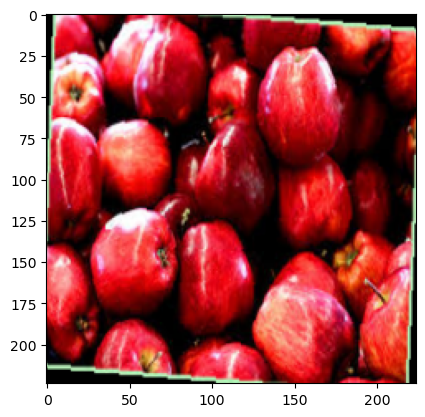

In [11]:
sample_image, sample_label = train_dataset[40]
plt.imshow(sample_image.permute(1,2,0))

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
len(train_loader)

72

In [19]:
class FruitClassifier(nn.Module):

  def __init__(self, num_classes=10):
    super().__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer5 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2))


    # fc layer start

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(7*7*512, 1024),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1024, 128),
        nn.ReLU()
    )

    self.fc3 = nn.Sequential(
        nn.Linear(128, num_classes),
    )


  def forward(self, X):
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)

    # Flattening
    out = out.reshape(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

model = FruitClassifier().to(device)
summary(model, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 112, 112]        --
├─Sequential: 1-2                        [-1, 128, 56, 56]         --
|    └─Conv2d: 2-5                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-6                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-8                    [-1, 128, 56, 56]         --
├─Sequential: 1-3                        [-1, 256, 28, 28]         --
|    └─Conv2d: 2-9                       [-1, 256, 56, 56]         295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 56, 56]         512


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 112, 112]        --
├─Sequential: 1-2                        [-1, 128, 56, 56]         --
|    └─Conv2d: 2-5                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-6                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-8                    [-1, 128, 56, 56]         --
├─Sequential: 1-3                        [-1, 256, 28, 28]         --
|    └─Conv2d: 2-9                       [-1, 256, 56, 56]         295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 56, 56]         512


In [54]:

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}.")

In [23]:

# COMMENTING code as the model have trained partially and loading the saved state to continue training

# EPOCHS = 30
# model = FruitClassifier().to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train_loss = []

# for i in range(EPOCHS):
#   mini_batch_losses = []
#   model.train()
#   for x,y in train_loader:
#     x = x.to(device)
#     y = y.to(device)

#     pred = model(x)
#     optimizer.zero_grad()
#     loss = loss_fn(pred, y)
#     mini_batch_losses.append(loss.item())

#     loss.backward()
#     optimizer.step()

#   avg_mini_batch_loss = np.mean(mini_batch_losses)
#   print(avg_mini_batch_loss)
#   train_loss.append(avg_mini_batch_loss)
#   save_checkpoint(model, optimizer, i+1, avg_mini_batch_loss)

In [25]:
# def evaluate_model(model, val_loader):
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Accuracy of the model: {accuracy:.2f}%')
#     return accuracy

# accuracy = evaluate_model(model, val_loader)

## Continuing training from saved state

In [60]:
model = FruitClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('checkpoints/checkpoint_epoch_60.pth', weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
prev_loss = checkpoint['loss']

start_epoch, prev_loss

(60, 0.12295012032457937)

In [62]:
train_loss = []
loss_fn = nn.CrossEntropyLoss()

end_epoch=90
for i in range(start_epoch, end_epoch):
  mini_batch_losses = []
  model.train()
  for x,y in train_loader:
    x = x.to(device)
    y = y.to(device)

    pred = model(x)
    optimizer.zero_grad()
    loss = loss_fn(pred, y)
    mini_batch_losses.append(loss.item())

    loss.backward()
    optimizer.step()

  avg_mini_batch_loss = np.mean(mini_batch_losses)
  print(avg_mini_batch_loss)
  train_loss.append(avg_mini_batch_loss)
    
save_checkpoint(model, optimizer, i+1, avg_mini_batch_loss)

0.1272050719966905
0.14306342464664745
0.12635716669157976
0.13063058658089075
0.11092049175769919
0.12521408767335945
0.13271529237843221
0.09770561083375166
0.11690280291562279
0.12305673478274709
0.10049492717047946
0.09624652034189138
0.11457826796039525
0.09731540435718165
0.11258965368486112
0.13260381331201643
0.1228261876385659
0.09925952142414947
0.10801726978065239
0.06271014063450922
0.061932040287906095
0.09513720410824236
0.09450637590554026
0.11275692086847913
0.13779722328763455
0.09126832170618905
0.09008292128176738
0.07353415638984491
0.06963301168030335
0.07169320435625398
Checkpoint saved at epoch 90.


In [64]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model: {accuracy:.2f}%')
    return accuracy

accuracy = evaluate_model(model, val_loader)

Accuracy of the model: 79.61%


### testing with eval images

In [75]:
from PIL import Image

In [116]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = './eval-image/apples.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image)
image = image.unsqueeze(0)

In [118]:
image =  image.to(device)

In [120]:
with torch.no_grad():
    pred = model(image)
    print(pred)

tensor([[ 13.8316,  -9.5016,  -2.1780,   0.6567,  -6.9080,   0.2321,  -5.6387,
         -16.0730,   0.4527,  -4.9005]], device='cuda:0')


In [122]:
torch.argmax(pred)

tensor(0, device='cuda:0')